In [1]:
import pImpactR as impact
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as copy
rectangular_ = 1
elliptic_ = 2

In [2]:
npt = 1
nturn = 1024

# read Aperture

In [3]:
aperture = np.loadtxt('pipeinfo.in')

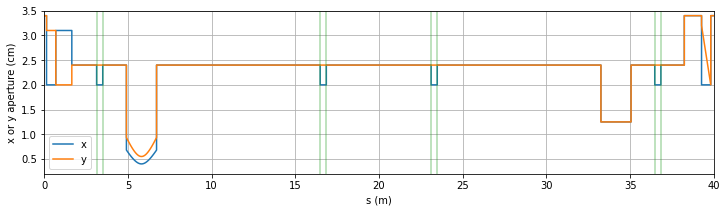

In [4]:
plt.figure(figsize=(12,3))
plt.plot(aperture[:,0],aperture[:,1]*100)
plt.plot(aperture[:,0],aperture[:,2]*100)
plt.plot(aperture[:,0],(aperture[:,3]-1)*10,alpha=0.4)
plt.grid()
plt.ylim((0.2,3.5))
plt.xlim((0.0, 40))
plt.legend(('x','y'))
plt.xlabel('s (m)')
plt.ylabel('x or y aperture (cm)');

In [5]:
aperture[-1,0]

39.968229720000004

# read impact lattice

In [6]:
beam,lattice = impact.readInputFile('test.Chad.in')

ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

g = ke/mass+1.0
bg = np.sqrt(g**2-1.0)

reading ImpactZ input file (test.Chad.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [7]:
beam.distribution.distribution_type = 'ReadFile'
beam.n_particles = 1
beam.nCore_y = 1
beam.nCore_z = 1

In [8]:
cleanLat = []
pre = lattice[0]
L = 0 
for item in lattice:
    if item.type == 'RFkick':
        item.vmax = 0.0
    if item.type == 'nonlinear_insert':
        item.type = 'drift'
        print('NL:',L,L+item.length)
    if item.type not in ['-8', 'write_raw_ptcl', 'halt']:
        cleanLat.append(item)
    if 'length' in item:
        L = L+item.length
print(L-aperture[-1,0])

NL: 4.9115191429 6.711519142899999
-4.199918635094946e-09


In [10]:
for item in cleanLat:
    if item.type == 'dipole':
        item.file_id = 150
        item.pipe_radius = item.pipe_radius/2

## Prepare pData

In [11]:
pData = np.zeros([1,9])
q_m = beam.multi_charge.q_m[0]
pData[0,0] = 0.01
pData[0,2] = 0.01
pData[:,-1] = 1
pData[:,-3] = q_m
beam.n_particles = 1

impact.writeParticleData(pData, ke, mass, freq)

# run Impact

In [12]:
for item in cleanLat:
    if 'length' in item:
        item.n_sckick = int(np.ceil(item.length*50))
        item.n_map = 1

In [13]:
cleanLat.insert(0,impact.getElem('pipeinfo'))
cleanLat[1].turns = nturn

In [14]:
M=impact.getTransferMap(beam,cleanLat)
M.values[4,:4]=M.values[4,:4]/freq/360*3.0e8
M.values[4,-1]=M.values[4,-1]/freq/360*3.0e8
M.values[:5,-1]=-M.values[:5,-1]*mass*bg

In [15]:
M

,0,1,2,3,4,5
0,-0.335771,0.533318,-0.026747,-0.000267,-0.002675,1.833229e+06
1,-1.729781,-0.309371,-0.034637,-0.000344,-0.003464,2.373972e+06
2,0.000000,0.000000,-0.309017,1.317348,0.000000,-0.000000e+00
3,0.000000,0.000000,-0.686613,-0.309017,0.000000,-0.000000e+00
4,-0.129865,-3.403546,4.334002,0.043675,16.602405,-2.970492e+08
5,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00
